In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
from metal.contrib.slicing.synthetics.geometric_synthetics import *

In [2]:
k = 2
m = 30
n = 5000

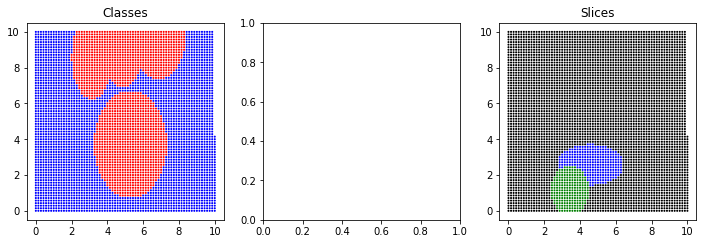

In [3]:
L, X, Y, Z = generate_dataset(k, m, n, Z_kwargs={'num_slices': 3})

### Analyze Data

In [4]:
from scipy.sparse import csr_matrix
import torch

L = csr_matrix(L)
X = torch.Tensor(X)

In [5]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True, seed=123)

In [6]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.116,0.116,0.076,49,9,0.844828
1,"[1, 2]",0.130,0.128,0.100,51,14,0.784615
2,"[1, 2]",0.076,0.072,0.060,31,7,0.815789
3,"[1, 2]",0.308,0.306,0.226,130,24,0.844156
4,"[1, 2]",0.280,0.272,0.200,87,53,0.621429
5,"[1, 2]",0.172,0.172,0.130,64,22,0.744186
6,2,0.030,0.030,0.018,15,0,1.000000
7,"[1, 2]",0.356,0.348,0.302,103,75,0.578652
8,"[1, 2]",0.046,0.046,0.034,17,6,0.739130
9,"[1, 2]",0.342,0.342,0.270,127,44,0.742690


In [7]:
# num_votes = Ls[0].sum(axis=1)
# plt.hist(num_votes)

In [ ]:
# np.save('synthetic_data.npy', (L, Y))

# Learn

In [ ]:
# L, Y = np.load('synthetic_data.npy')

### Snorkel LabelModel

In [8]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

Inferred cardinality: 2


In [9]:
from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Y_train_p = label_model.predict(Ls[0])

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.808

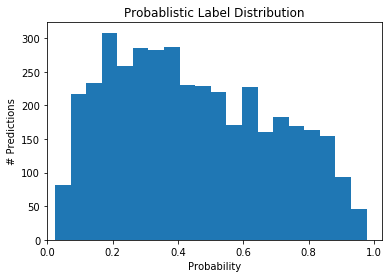

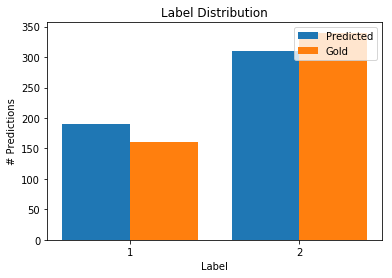

In [10]:
from metal.contrib.visualization.analysis import (
    plot_predictions_histogram, 
    plot_probabilities_histogram,
)
    
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

## Compare Baselines

In [ ]:
# from torch.utils.data import DataLoader
# from metal.utils import SlicingDataset
# from metal.contrib.slicing.utils import evaluate_slicing

# eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

# results = {}
# for model_name, model in trained_models.items():
#     scores = evaluate_slicing(model, eval_loader, verbose=False)
#     results[model_name] = {k:v['accuracy'] for k,v in scores.items()}
    
# import pandas as pd
# pd.DataFrame.from_dict(results)

### EndModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

train_loader = DataLoader(
    SlicingDataset(Xs[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

In [ ]:
from metal.end_model import EndModel
import torch

end_model = EndModel([2,10,10,2])
end_model.train_model(train_loader, dev_data=(Xs[1], Ys[1]), l2=0.0, 
                      n_epochs=25, print_every=5, validation_metric='accuracy', 
                      disable_prog_bar=True)
end_model.score((Xs[1], Ys[1]))

### SliceModel

In [ ]:
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Xs[0], Ls_tensors[0], Y_train_ps),
    batch_size=256,
    shuffle=True
)

dev_loader = DataLoader(
    SlicingDataset(Xs[1], Ys[1]),
    batch_size=256,
)

In [ ]:
import torch.nn as nn
from metal.contrib.slicing.online_dp import SliceDPModel, MLPModule

n, m = Ls[0].shape
input_dim = Xs[0].shape[1]

input_module = MLPModule(input_dim, 10, [10], bias=True)
slice_model = SliceDPModel(input_module, r=10, m=m, reweight=False, slice_weight=0.1, 
                           verbose=False)
slice_model.train_model(
    train_loader,
    dev_data=dev_loader,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

### New SliceModel

In [ ]:
from metal.contrib.slicing.online_dp import SliceHatModel

# base_model = EndModel([2,20,20,2], verbose=False)
slicer = SliceHatModel(end_model, m, slice_weight=0.1)

slicer.train_model(
    train_loader,
    dev_data=dev_loader,
    lr=0.05,
    l2=0.0, n_epochs=50,
    print_every=5, validation_metric='accuracy',
    log_writer=None,
    verbose=True, 
    use_cuda=False,
    disable_prog_bar=True,
)

In [ ]:
from metal.contrib.slicing.utils import evaluate_slicing

from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

eval_loader = DataLoader(SlicingDataset(Xs[1], Ys[1], Zs[1]))

_ = evaluate_slicing(end_model, eval_loader, verbose=False)
_ = evaluate_slicing(slice_model, eval_loader, verbose=False)
_ = evaluate_slicing(slicer, eval_loader, verbose=False)

In [ ]:
# L_pred = np.round(slicer.predict_L_proba(Xs[1]).numpy())
# L_pred[L_pred == 0] = 2
# accuracy_score(Ls[1].reshape(-1,1), L_pred.reshape(-1,1), ignore_in_gold=[0])

In [ ]:
# ((Ls[1] == L_pred).sum(axis=0)/(Ls[1] != 0).sum(axis=0)).mean()

### Repeated Trials

In [ ]:
# Grid search as necessary first


In [ ]:
from metal.utils import split_data, SlicingDataset
from metal.label_model.baselines import MajorityLabelVoter
from metal.end_model import EndModel
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel
from metal.contrib.slicing.synthetics.geometric_synthetics import *
from metal.contrib.slicing.online_dp import SliceHatModel
from metal.contrib.slicing.utils import evaluate_slicing

import torch
from torch.utils.data import DataLoader

NUM_TRIALS = 3
SPLIT = 2

k = 2
m = 30
n = 5000

batchsize = 32
layer_output_dims = [2, 10, 10, 2]
slice_weight = 0.1

summary = {}
for model in ['mv', 'dp', 'up', 'me', 'sm']:
    summary[model] = {
        'overall': [],
        'slices': []
    }

for i in range(NUM_TRIALS):
    L, X, Y, Z = generate_dataset(k, m, n, plotting=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    lm = SnorkelLabelModel()
    lm.train_model(Ls[0])
    Y_train_ps = lm.predict_proba(Ls[0])

    dev_loader = DataLoader(
        SlicingDataset(Xs[1], Ys[1]),
        batch_size=256,
    )
    eval_loader = DataLoader(SlicingDataset(Xs[2], Ys[2], Zs[2]))
    
    # Train dp
    em_train_loader = DataLoader(
        SlicingDataset(Xs[0], Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )    
    
    dp = EndModel(layer_output_dims)
    dp.train_model(
        em_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )

    dp_results = evaluate_slicing(dp, eval_loader, verbose=False)
    summary['dp']['overall'].append(dp_results['all']['accuracy'])
    for s in range(1,5):
        summary['dp']['slices'].append(dp_results[f'slice_{s}']['accuracy'])    
    
    # Train dp_sm
    L_train = torch.Tensor(np.asarray(Ls[0].todense()))    
    sm_train_loader = DataLoader(
        SlicingDataset(Xs[0], L_train, Y_train_ps),
        batch_size=batchsize,
        shuffle=True
    )
    
    dp = EndModel(layer_output_dims) # Fresh copy to be safe
    sm = SliceHatModel(dp, m, slice_weight=slice_weight)
    sm.train_model(
        sm_train_loader,
        dev_data=dev_loader,
        lr=0.05,
        l2=0.0, 
        n_epochs=50,
        print_every=5, 
        validation_metric='accuracy',
        verbose=True, 
        use_cuda=False,
        disable_prog_bar=True,
    )
    
    sm_results = evaluate_slicing(sm, eval_loader, verbose=False)
    summary['sm']['overall'].append(sm_results['all']['accuracy'])
    for s in range(1,5):
        summary['sm']['slices'].append(sm_results[f'slice_{s}']['accuracy'])

print(summary['dp'])
print(summary['sm'])

In [11]:
from metal.contrib.slicing.online_dp import SliceHatModel, MLPModule
from metal.end_model import EndModel

dp_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "L_weights": None
}

up_config = {
    "base_model_class" : EndModel,
    "base_model_init_kwargs": {
        "layer_out_dims": [5, 2],
        "input_layer_config": {
            "input_relu": False,
            "input_batchnorm": False,
            "input_dropout": 0.0,
        },
        "input_module": MLPModule(**{
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
        })
    },
    "train_on_L": False,
    "L_weights": [2, 1, 1]    
}

moe_config = {
    "base_model_class" : EndModel,
    "base_model_init_kwargs": {
        "layer_out_dims": [5, 2],
        "input_layer_config": {
            "input_relu": False,
            "input_batchnorm": False,
            "input_dropout": 0.0,
        },
        "input_module": MLPModule(**{
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
        })
    },
    "train_on_L": False,
    "mixture_of_experts": True,
    "L_weights": None
},    


sm_config = {
    "end_model_init_kwargs": {
        "layer_out_dims": [2, 10, 10, 2]
    },
    "slice_kwargs": {
        "slice_weight": 0.1,
    },
    "L_weights": None
}

model_configs = {
#     "DP": dp_config,
#     "UPx2": up_config,
#     "MoE": moe_config,
    "SM": sm_config,
}

In [12]:
from metal.contrib.slicing.experiment_utils import (
    create_data_loaders,
    train_model,
    eval_model
)

---------- Training SM ----------
Inferred cardinality: 2

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=10, out_features=2, bias=True)
)

Resetting base model parameters
SliceHatModel(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=10, out_features=30, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=20, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
)



/dfs/scratch0/vschen/snorkel-pytorch/venv/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Saving model at iteration 0 with best score 0.750
[E:0]	Train Loss: 0.620	Dev accuracy: 0.750
Saving model at iteration 1 with best score 0.768
[E:1]	Train Loss: 0.615	Dev accuracy: 0.768
Saving model at iteration 2 with best score 0.840
[E:2]	Train Loss: 0.614	Dev accuracy: 0.840
[E:3]	Train Loss: 0.613	Dev accuracy: 0.820
[E:4]	Train Loss: 0.613	Dev accuracy: 0.810
[E:5]	Train Loss: 0.612	Dev accuracy: 0.824
[E:6]	Train Loss: 0.611	Dev accuracy: 0.812
Saving model at iteration 7 with best score 0.852
[E:7]	Train Loss: 0.611	Dev accuracy: 0.852
[E:8]	Train Loss: 0.611	Dev accuracy: 0.852


100%|██████████| 16/16 [00:00<00:00, 4341.93it/s]

Saving model at iteration 9 with best score 0.862
[E:9]	Train Loss: 0.610	Dev accuracy: 0.862
Restoring best model from iteration 9 with score 0.862
Finished Training
Accuracy: 0.862
        y=1    y=2   
 l=1    187    50    
 l=2    19     244   
All: 500 examples


Accuracy: 0.874
Precision: 0.809
Recall: 0.894
F1: 0.850
        y=1    y=2   
 l=1    178    42    
 l=2    21     259   

Slice 0: 406 examples
Accuracy: 0.860
Precision: 0.826
Recall: 0.891
F1: 0.857
        y=1    y=2   
 l=1    171    36    
 l=2    21     178   

Slice 1: 11 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     11    

Slice 2: 27 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     27    

Slice 3: 16 examples
Accuracy: 1.000
Precision: 0.000
Recall: 0.000
F1: 0.000
        y=1    y=2   
 l=1     0      0    
 l=2     0     16    

Slice 4: 40 examples
Accuracy: 0.850
Precision: 0.538
Recall: 1.000
F1: 0.700
        y=1    y=2   
 l=1     7      6    
 l=2     0     27    

SUMMARY (accuracies):
All: 0.874
Slice 0: 0.8596059113300493
Slice 1: 1.0
Slice 2: 1.0
Slice 3: 1.0
Slice 4: 0.85


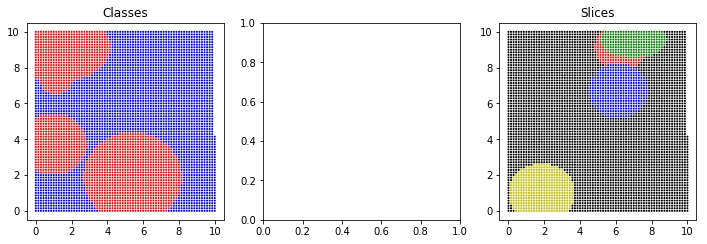

In [13]:
from collections import defaultdict


NUM_TRIALS = 1
k = 2
m = 30
n = 5000
num_slices = 3

history = defaultdict(list)
for trial in range(NUM_TRIALS):

    L, X, Y, Z, targeting_lfs_idx = generate_dataset(k, m, n, return_targeting_lfs=True)
    Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.8, 0.1, 0.1], shuffle=True)
    
    for model_name, model_config in model_configs.items():
        print ("-"*10, "Training", model_name, "-"*10)
        train_ds, dev_ds, test_ds = create_data_loaders(Ls, Xs, Ys, Zs, model_config)

        if model_name == 'up':
            pass
        elif model_name == 'moe':
            pass
        else:
            model = train_model(model_config, train_ds, dev_ds, m)

        results = eval_model(model, test_ds)        
        
        # Save results
        history[model_name].append(results)